# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. The model we want to use is:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Lognormal}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

Alternatively, for normal data:
\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \mathcal{N}(0, 1) \\
\sigma & \sim \text{Gamma}(.5, .5) \\
x_{svg} \mid \beta_{vg} &  \sim  \mathcal{N}\left(l_{vg} + \beta_{vg}, \sigma^2 \right) \\
\end{align}

We start with some simple models, see them in the other notebooks.

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os

In [5]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [6]:
from sklearn.preprocessing import LabelEncoder
from pymc3 import  model_to_graphviz

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(1, 1) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau_g^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau_b^2) \\
l_{cgs} & \sim \text{Lognormal}(1, 1) \\
x_{cgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left( \beta_{cg} \right) \right) \\
\end{align}

## Data

Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

In [118]:
infile = "/home/simon/PROJECTS/cell_lines/src/shm/data_raw/read_counts_parsed.tsv"

In [119]:
def _load_data(infile, normalize=False):    
    dat = pd.read_csv(infile, sep="\t")
    if normalize:
        dat["cm"] = np.mean(dat[["c1", "c2"]].values, axis=1)
        dat["r1"] = np.log(dat["r1"].values / dat["cm"].values)
        dat["r2"] = np.log(dat["r2"].values / dat["cm"].values)
    dat = dat.query("Gene == 'PSMB1' | Gene == 'PSMC1' | Gene == 'PSMC5' | Gene == 'BCR'")     
    dat = (dat[["Condition", "Gene", "sgRNA", "r1", "r2"]]
           .query("Gene != 'Control'")
           .melt(id_vars=["Gene", "Condition", "sgRNA"],
                 value_vars=["r1", "r2"],
                 var_name="replicate",
                 value_name="counts")
           .sort_values(["Gene", "Condition", "sgRNA", "replicate"])
    )
    dat["sgRNA"] = LabelEncoder().fit_transform(dat["sgRNA"].values)
    if not normalize:
        dat["counts"] = sp.floor(dat["counts"].values)
    return dat

In [120]:
read_counts = _load_data(infile, True)

In [121]:
read_counts

,Gene,Condition,sgRNA,replicate,counts
0,BCR,Neuron,0,r1,-0.072450
40,BCR,Neuron,0,r2,-0.153482
1,BCR,Neuron,1,r1,-0.049086
41,BCR,Neuron,1,r2,-0.141003
2,BCR,Neuron,2,r1,-0.049702
42,BCR,Neuron,2,r2,-0.139791
3,BCR,Neuron,3,r1,-0.039308
43,BCR,Neuron,3,r2,-0.119144
4,BCR,Neuron,4,r1,-0.039271
44,BCR,Neuron,4,r2,-0.133920


## Inference

In [95]:
n, _ = read_counts.shape
le = LabelEncoder()

gene_idx = le.fit_transform(read_counts["Gene"].values)
con_idx = le.fit_transform(read_counts["Condition"].values)

len_genes = len(sp.unique(gene_idx))
len_conditions = len(sp.unique(con_idx))
len_sirnas = len(sp.unique(read_counts["sgRNA"].values))
len_replicates = len(sp.unique(read_counts["replicate"].values))
len_sirnas_per_gene = int(len_sirnas / len_genes)

beta_idx = np.tile(range(len_genes), len_conditions)
beta_data_idx = np.repeat(beta_idx, int(n / len(beta_idx)))

l_idx = np.repeat(range(len_sirnas), len_replicates )

In [134]:
with pm.Model() as model:
    p = pm.Dirichlet("p", a=np.array([0.5, 0.5]), shape=2)
    pm.Potential("p_pot", tt.switch(tt.min(p) < 0.05, -np.inf, 0))
    category = pm.Categorical("category", p=p, shape=len_genes)

    tau_g = pm.Gamma("tau_g", .1, .1, shape=1)
    mean_g = pm.Normal("mu_g", mu=np.array([0, 0]), sd=0.5, shape=2)
    pm.Potential("m_opot", tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))
    gamma = pm.Normal("gamma", mean_g[category], tau_g, shape=len_genes)

    tau_b = pm.Gamma("tau_b", .1, .1, shape=1)
    if len_conditions == 1:
        beta = pm.Deterministic("beta", gamma)
    else:
        beta_non = pm.Normal('beta_non', 0, 1, shape= len(beta_idx))
        beta = pm.Deterministic("beta", gamma[beta_idx] + tau_b * beta_non)
    l = pm.Normal("l", 0, .25, shape=len_sirnas * 2)

    pm.Normal(
      "x",
      mu =      beta[beta_data_idx] + l[l_idx],
      observed = sp.squeeze(read_counts["counts"].values),
    )

In [112]:
mod = model_to_graphviz(model)

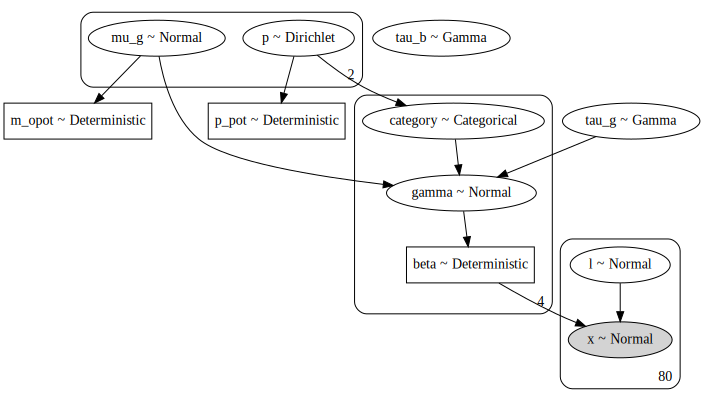

In [123]:
mod

In [ ]:
with model:
    trace = pm.sample(1000, n_init=10000, tune=5000, chains=2, seed=23)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [l, tau_b, gamma, mu_g, tau_g, p]
>BinaryGibbsMetropolis: [category]
Sampling 2 chains:  53%|█████▎    | 6391/12000 [00:45<00:29, 191.09draws/s]

In [129]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 4, category_dim_0: 4, gamma_dim_0: 4, l_dim_0: 80, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3
Data variables:
    category        (category_dim_0) float64 1.02 1.02 1.04 1.07
    mu_g            (mu_g_dim_0) float64 1.07 1.01
    gamma           (gamma_dim_0) float64 1.03 1.01 1.01 1.01
    l               (l_dim_0) float64 1.01 1.01 1.0 1.02 ... 1.01 1.01 1.02 1.0
    p               (p_dim_0) float64 1.05 1.05
    tau_g           (tau_g_dim_0) float64 1.01
    tau_b           (tau_b_dim_0) float64 1.0
    beta           

In [126]:
az.effective_sample_size(trace)

<xarray.Dataset>
Dimensions:         (beta_dim_0: 4, category_dim_0: 4, gamma_dim_0: 4, l_dim_0: 80, mu_g_dim_0: 2, p_dim_0: 2, tau_b_dim_0: 1, tau_g_dim_0: 1)
Coordinates:
  * category_dim_0  (category_dim_0) int64 0 1 2 3
  * mu_g_dim_0      (mu_g_dim_0) int64 0 1
  * gamma_dim_0     (gamma_dim_0) int64 0 1 2 3
  * l_dim_0         (l_dim_0) int64 0 1 2 3 4 5 6 7 ... 72 73 74 75 76 77 78 79
  * p_dim_0         (p_dim_0) int64 0 1
  * tau_g_dim_0     (tau_g_dim_0) int64 0
  * tau_b_dim_0     (tau_b_dim_0) int64 0
  * beta_dim_0      (beta_dim_0) int64 0 1 2 3
Data variables:
    category        (category_dim_0) float64 19.0 25.0 22.0 22.0
    mu_g            (mu_g_dim_0) float64 34.0 12.0
    gamma           (gamma_dim_0) float64 43.0 88.0 88.0 122.0
    l               (l_dim_0) float64 350.0 49.0 216.0 35.0 ... 31.0 200.0 44.0
    p               (p_dim_0) float64 19.0 19.0
    tau_g           (tau_g_dim_0) float64 77.0
    tau_b           (tau_b_dim_0) float64 290.0
    beta        

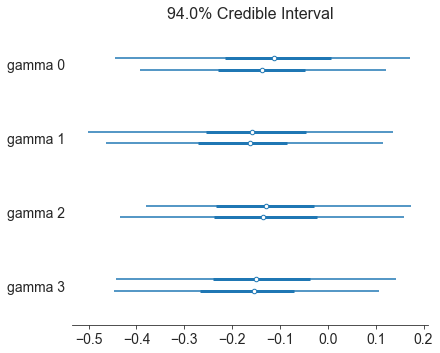

In [130]:
az.plot_forest(trace, var_names="gamma");

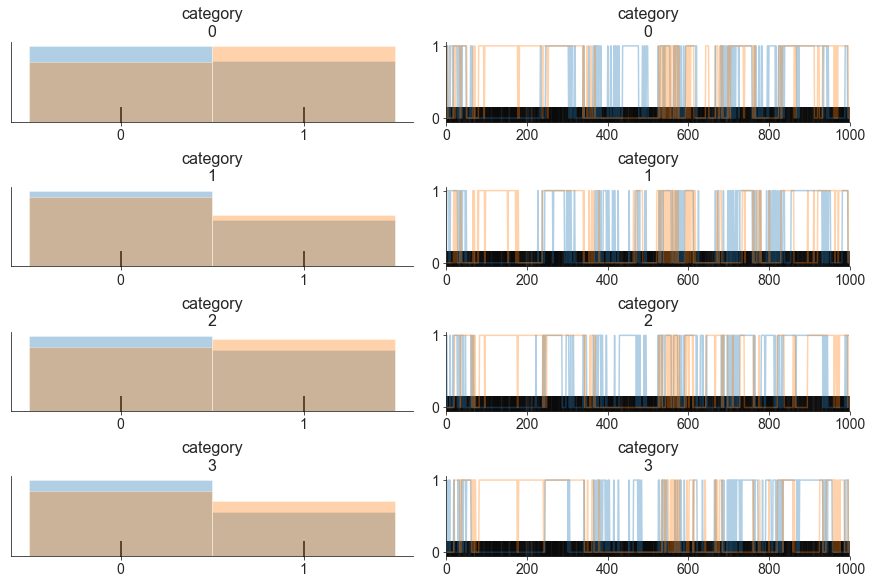

In [133]:
az.plot_trace(trace, var_names="category");